In [43]:
import os
%load_ext autoreload
%autoreload 2

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
import cmasher as cmr
from matplotlib import colors
from astroquery.gaia import Gaia


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:


data_dir = "/data/jdli/lamost/"
cat = Table.read(data_dir+"slam_snrg100.fits")

names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()
print(df_raw.shape, df_raw.columns)

(142608, 114) Index(['obsid', 'ra', 'dec', 'snrg', 'teff_slam', 'logg_slam', 'mh_slam',
       'am_slam', 'cm_slam', 'nm_slam',
       ...
       'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X',
       'MeasureJD', 'angDist'],
      dtype='object', length=114)


In [6]:
import sys
sys.path.append("/home/jdli/transpec")
from kvxp.vis import *

In [2]:
gaia = pd.read_csv("/nfsdata/users/jdli_ny/JD_92m.csv")

print(gaia.shape, gaia.columns)


(91951421, 9) Index(['teff_xp', 'logg_xp', 'moh_xp', 'aom_xp', 'e_teff_xp', 'e_logg_xp',
       'e_moh_xp', 'e_aom_xp', 'source_id'],
      dtype='object')


In [4]:
# c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
# catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)

# idx, d2d, d3d = c.match_to_catalog_sky(catalog)

df = pd.merge(df_raw, gaia, left_on='Source', right_on='source_id')
print(df.shape)

(25960, 123)


In [34]:
mask = (df['BP-RP']>1) & (df['BP-RP']<3.5) & (df['BPmag']<15.5)

gdf = df[mask].copy()
gdf.shape

(25238, 123)

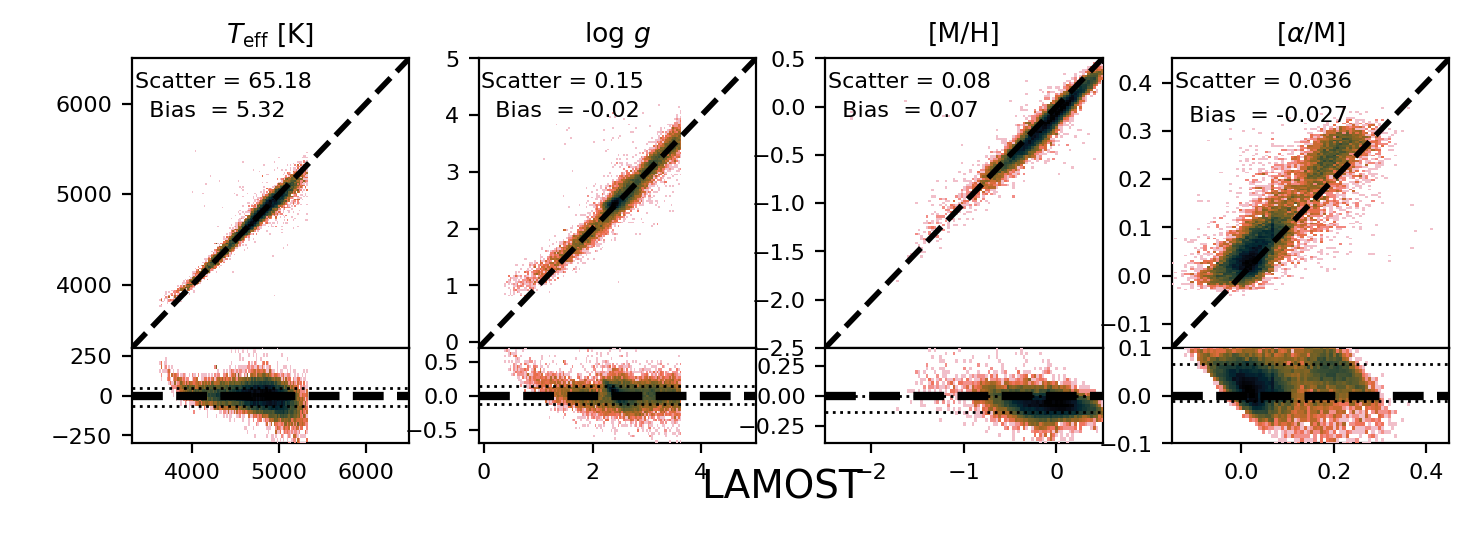

In [49]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['teff_slam', 'logg_slam', 'mh_slam', 'am_slam']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.4, 0.4], [-0.1, 0.1]]
# xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$ [K]', 'log $g$', '[M/H]', r'[$\alpha$/M]']
# y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
    
    text_stats_default = False if i==3 else True

    ax1, ax2 = draw_hist2d(
        axs[i], gdf[true_names[i]], gdf[ynames[i]],
        xrange=xranges[i], bins=100, text_stats=text_stats_default,
        cmap='cmr.dusk_r'
    )
    ax1.set_xticks([]); 
    ax1.set_ylabel(" ");
    ax1.set_title(ylabels[i])
    # ax2.set_xlabel(xlabels[i]);
    # ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    ax2.set_xlabel(" "); ax2.set_ylabel(" ");
    
    if i==3:
        res = gdf[true_names[i]]-gdf[ynames[i]]
        ax1.text(0.01, 0.9, "Scatter = %.3f"%(0.5*(np.percentile(res, 84)-np.percentile(res, 16))),
                transform=ax1.transAxes, zorder=6)
        ax1.text(0.01, 0.78, "  Bias  = %.3f"%(np.median(res)),
                transform=ax1.transAxes, zorder=6)

fig.subplots_adjust(wspace=0.25, hspace=0)

fig.text(0.46, 0.00, "LAMOST", fontsize=14)
fig.savefig("../fig/compare4d_lamost.pdf")


(23827, 123)


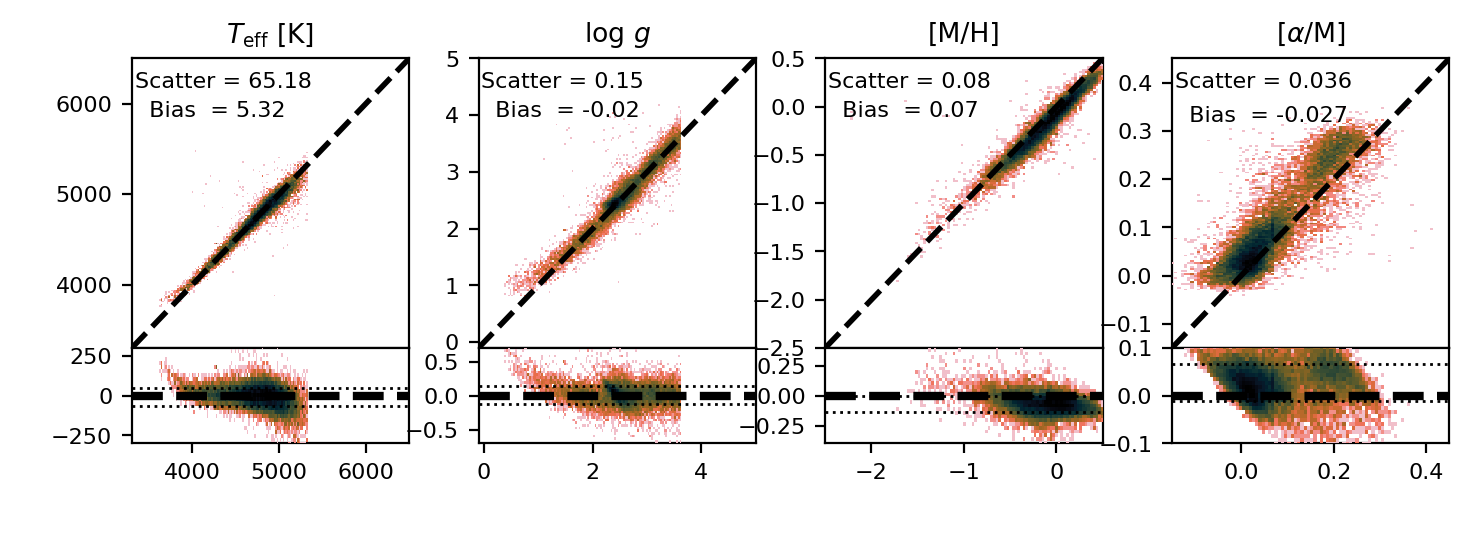

In [50]:
mask =  (df['BP-RP']>1) & (df['BP-RP']<3.5) & (df['BPmag']<15.5) &\
        (df['e_aom_xp']<0.05) & (df['e_moh_xp']<0.1) &\
        (df['teff_xp']*df['e_teff_xp']**-1>10) &\
        (df['logg_xp']*df['e_logg_xp']**-1>10)

gdf = df[mask].copy()
print(gdf.shape)

fig, axs = plt.subplots(1,4, figsize=(8.5, 2.5))

rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['teff_slam', 'logg_slam', 'mh_slam', 'am_slam']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.4, 0.4], [-0.1, 0.1]]
# xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = [r'$T_{\rm eff}$ [K]', 'log $g$', '[M/H]', r'[$\alpha$/M]']
# y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
    
    text_stats_default = False if i==3 else True

    ax1, ax2 = draw_hist2d(
        axs[i], gdf[true_names[i]], gdf[ynames[i]],
        xrange=xranges[i], bins=100, text_stats=text_stats_default,
        cmap='cmr.dusk_r'
    )
    ax1.set_xticks([]); 
    ax1.set_ylabel(" ");
    ax1.set_title(ylabels[i])
    # ax2.set_xlabel(xlabels[i]);
    # ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);
    ax2.set_xlabel(" "); ax2.set_ylabel(" ");
    
    if i==3:
        res = gdf[true_names[i]]-gdf[ynames[i]]
        ax1.text(0.01, 0.9, "Scatter = %.3f"%(0.5*(np.percentile(res, 84)-np.percentile(res, 16))),
                transform=ax1.transAxes, zorder=6)
        ax1.text(0.01, 0.78, "  Bias  = %.3f"%(np.median(res)),
                transform=ax1.transAxes, zorder=6)

fig.subplots_adjust(wspace=0.25, hspace=0)

fig.savefig("../fig/compare4d_lamost_hi.pdf")